# Lending Club Default Risk - Gradient Boosting Comparison

This notebook orchestrates an end-to-end workflow for predicting loan default risk using Lending Club's accepted loan data. Core business logic lives in reusable modules under `src/`, keeping the notebook focused on analysis and reporting.

## Workflow Overview
- Load Lending Club accepted-loan data from the local `data/` directory
- Clean and engineer features via shared `src.pipeline` utilities
- Perform chronological splits to avoid look-ahead bias
- Train and tune gradient boosting pipelines (XGBoost & LightGBM) with `RandomizedSearchCV`
- Evaluate performance with standard classification metrics and diagnostic plots
- Explain the top-performing model with permutation importance and optional SHAP summaries
- Export the trained artifacts, metrics, and predictions into `artifacts/`

## Project Setup
The notebook expects the module code under `src/` to be on the Python path (default when executed from the project root).

In [1]:
# Optional: ensure required packages are installed (uncomment to run)
# %pip install -q pandas numpy scikit-learn xgboost lightgbm shap joblib matplotlib seaborn tqdm

In [2]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from IPython.display import display

from sklearn.base import clone
from src.config import (
    ARTIFACT_DIR,
    CONFIG,
    MODEL_FEATURES,
    RAW_FEATURES,
    get_accepted_data_path,
)
from src.pipeline import (
    compute_scale_pos_weight,
    prepare_model_dataset,
    run_lightgbm_random_search,
    run_random_search,
    time_based_split,
)
from src.reporting import (
    compute_shap_importances,
    confusion_matrix_dataframe,
    evaluate_split,
    permutation_importance_summary,
    plot_diagnostics,
    save_best_params,
    save_feature_importances,
    save_metrics,
    save_pipeline,
    save_predictions,
)

sns.set_theme(style="whitegrid")
warnings.filterwarnings("ignore", category=UserWarning)
plt.rcParams["figure.figsize"] = (10, 6)
np.random.seed(CONFIG["random_state"])


/Users/yuanhaowen/anaconda3/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


## 1. Load & Inspect Data

In [14]:
pd.set_option('display.max_columns', None)

In [15]:
accepted_path = get_accepted_data_path()
print(f"Accepted data source: {accepted_path}")

df_raw = pd.read_csv(
    accepted_path,
    usecols=RAW_FEATURES,
    low_memory=False,
)

print(f"Raw shape: {df_raw.shape}")
display(df_raw.head())
print("Loan status counts (top 10):")
display(df_raw['loan_status'].value_counts().head(10).to_frame(name='count'))


Accepted data source: /Users/yuanhaowen/Desktop/Project/XGBoost/data/accepted_2007_to_2018Q4.csv
Raw shape: (2260701, 36)


,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,application_type,tot_cur_bal,total_rev_hi_lim,chargeoff_within_12_mths,mort_acc,mths_since_recent_inq,pub_rec_bankruptcies,tax_liens
0,3600.0,36 months,13.99,123.03,C,C4,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,debt_consolidation,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,7.0,0.0,2765.0,29.7,13.0,564.0,560.0,0.0,Individual,144904.0,9300.0,0.0,1.0,4.0,0.0,0.0
1,24700.0,36 months,11.99,820.28,C,C1,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,small_business,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,22.0,0.0,21470.0,19.2,38.0,699.0,695.0,0.0,Individual,204396.0,111800.0,0.0,4.0,0.0,0.0,0.0
2,20000.0,60 months,10.78,432.66,B,B4,10+ years,MORTGAGE,63000.0,Not Verified,Dec-2015,Fully Paid,home_improvement,IL,10.78,0.0,Aug-2000,695.0,699.0,0.0,6.0,0.0,7869.0,56.2,18.0,704.0,700.0,0.0,Joint App,189699.0,14000.0,0.0,5.0,10.0,0.0,0.0
3,35000.0,60 months,14.85,829.90,C,C5,10+ years,MORTGAGE,110000.0,Source Verified,Dec-2015,Current,debt_consolidation,NJ,17.06,0.0,Sep-2008,785.0,789.0,0.0,13.0,0.0,7802.0,11.6,17.0,679.0,675.0,0.0,Individual,301500.0,67300.0,0.0,1.0,NaN,0.0,0.0
4,10400.0,60 months,22.45,289.91,F,F1,3 years,MORTGAGE,104433.0,Source Verified,Dec-2015,Fully Paid,major_purchase,PA,25.37,1.0,Jun-1998,695.0,699.0,3.0,12.0,0.0,21929.0,64.5,35.0,704.0,700.0,0.0,Individual,331730.0,34000.0,0.0,6.0,1.0,0.0,0.0


Loan status counts (top 10):


,count
loan_status,
Fully Paid,1076751
Current,878317
Charged Off,268559
Late (31-120 days),21467
In Grace Period,8436
Late (16-30 days),4349
Does not meet the credit policy. Status:Fully Paid,1988
Does not meet the credit policy. Status:Charged Off,761
Default,40


## 2. Clean & Engineer Features

In [4]:
df_model = prepare_model_dataset(df_raw)
print(f"Model dataset shape: {df_model.shape}")

class_counts = df_model[CONFIG["target_column"]].value_counts().rename("count")
class_props = df_model[CONFIG["target_column"]].value_counts(normalize=True).rename("proportion")
display(pd.concat([class_counts, class_props], axis=1))
display(df_model.head())


/Users/yuanhaowen/Desktop/Project/XGBoost/src/pipeline.py:88: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["installment_to_income_ratio"].replace([np.inf, -np.inf], np.nan, inplace=True)


Model dataset shape: (1382351, 35)


,count,proportion
is_default,,
0.0,1078739,0.780365
1.0,303612,0.219635


,loan_amnt,term_months,int_rate_decimal,installment,emp_length_years,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,...,total_rev_hi_lim,grade,sub_grade,home_ownership,verification_status,purpose,addr_state,application_type,issue_d,is_default
0,5000.0,36.0,0.0775,156.11,10.0,70000.0,8.81,NaN,NaN,NaN,...,NaN,A,A3,MORTGAGE,Not Verified,other,CT,Individual,2007-06-01,0.0
1,7500.0,36.0,0.1375,255.43,0.5,22000.0,14.29,1.0,0.0,7.0,...,NaN,E,E2,OWN,Not Verified,debt_consolidation,MA,Individual,2007-06-01,0.0
2,6000.0,36.0,0.1059,195.28,0.5,20000.0,12.90,0.0,4.0,5.0,...,NaN,C,C2,RENT,Not Verified,debt_consolidation,CT,Individual,2007-06-01,0.0
3,4400.0,36.0,0.0964,141.25,2.0,30000.0,3.72,0.0,0.0,4.0,...,NaN,B,B4,MORTGAGE,Not Verified,debt_consolidation,NJ,Individual,2007-06-01,0.0
4,1200.0,36.0,0.0901,38.17,0.5,36000.0,3.27,NaN,NaN,NaN,...,NaN,B,B2,RENT,Not Verified,other,TX,Individual,2007-06-01,0.0


In [5]:
missing_ratio = df_model[MODEL_FEATURES].isna().mean().sort_values(ascending=False)
display(missing_ratio.head(15).to_frame("missing_ratio"))


,missing_ratio
mths_since_recent_inq,0.130042
emp_length_years,0.058912
tot_cur_bal,0.050838
total_rev_hi_lim,0.050838
mort_acc,0.036192
pub_rec_bankruptcies,0.000987
revol_util_decimal,0.000676
dti,0.000298
installment_to_income_ratio,0.000289
chargeoff_within_12_mths,0.000105


## 3. Chronological Train/Validation/Test Split

In [6]:
splits, cutoffs = time_based_split(df_model)
train_df, val_df, test_df = splits["train"], splits["val"], splits["test"]

print("Split sizes:")
print({k: len(v) for k, v in splits.items()})
print("Date cutoffs:")
print(cutoffs)

if CONFIG["max_training_rows"] and len(train_df) > CONFIG["max_training_rows"]:
    train_df = train_df.iloc[-CONFIG["max_training_rows"]:].reset_index(drop=True)
    print(f"Training set truncated to last {len(train_df)} rows for efficiency.")

X_train = train_df[MODEL_FEATURES]
y_train = train_df[CONFIG["target_column"]]
X_val = val_df[MODEL_FEATURES]
y_val = val_df[CONFIG["target_column"]]
X_test = test_df[MODEL_FEATURES]
y_test = test_df[CONFIG["target_column"]]

train_val_df = pd.concat([train_df, val_df], axis=0).sort_values(CONFIG["date_column"]).reset_index(drop=True)
X_train_val = train_val_df[MODEL_FEATURES]
y_train_val = train_val_df[CONFIG["target_column"]]

scale_pos_weight = compute_scale_pos_weight(y_train.to_numpy())
CONFIG["model_params"]["scale_pos_weight"] = scale_pos_weight
CONFIG["lightgbm_params"]["scale_pos_weight"] = scale_pos_weight
print(f"Positive rate (train): {y_train.mean():.4f} | scale_pos_weight: {scale_pos_weight:.2f}")


Split sizes:
{'train': 967645, 'val': 207353, 'test': 207353}
Date cutoffs:
{'train_end': Timestamp('2016-04-01 00:00:00'), 'val_end': Timestamp('2017-03-01 00:00:00'), 'test_end': Timestamp('2018-12-01 00:00:00')}
Training set truncated to last 600000 rows for efficiency.
Positive rate (train): 0.2089 | scale_pos_weight: 3.79


## 4. Pipeline Definition & Hyperparameter Search

In [7]:
tune_df = train_df.copy()
if CONFIG["tuning_sample_size"] and len(tune_df) > CONFIG["tuning_sample_size"]:
    tune_df = tune_df.iloc[-CONFIG["tuning_sample_size"]:]
    print(f"Tuning sample reduced to last {len(tune_df)} rows to speed up search.")

X_tune = tune_df[MODEL_FEATURES]
y_tune = tune_df[CONFIG["target_column"]]

search_results = {}
for model_name, runner in {"xgboost": run_random_search, "lightgbm": run_lightgbm_random_search}.items():
    print(f"\n--- Tuning {model_name.upper()} ---")
    search = runner(
        X_tune,
        y_tune,
        scale_pos_weight=scale_pos_weight,
    )
    print(f"Best ROC-AUC: {search.best_score_:.4f}")
    print("Best hyperparameters:")
    print(search.best_params_)
    search_results[model_name] = search


Tuning sample reduced to last 250000 rows to speed up search.

--- Tuning XGBOOST ---
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best ROC-AUC: 0.9599
Best hyperparameters:
{'classifier__subsample': 0.8, 'classifier__reg_lambda': 0.5, 'classifier__reg_alpha': 1.0, 'classifier__n_estimators': 300, 'classifier__min_child_weight': 5, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.03, 'classifier__gamma': 0.3, 'classifier__colsample_bytree': 1.0}

--- Tuning LIGHTGBM ---
Fitting 3 folds for each of 15 candidates, totalling 45 fits


/Users/yuanhaowen/anaconda3/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/Users/yuanhaowen/anaconda3/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/Users/yuanhaowen/anaconda3/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or 

[LightGBM] [Info] Number of positive: 12495, number of negative: 50005
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3223
[LightGBM] [Info] Number of data points in the train set: 62500, number of used features: 137
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199920 -> initscore=-1.386794
[LightGBM] [Info] Start training from score -1.386794
[LightGBM] [Info] Number of positive: 12495, number of negative: 50005
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006621 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3221
[LightGBM] [Info] Number of data points in the train set: 62500, number of used features: 136
[LightGBM] [Info

/Users/yuanhaowen/anaconda3/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/Users/yuanhaowen/anaconda3/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


[LightGBM] [Info] Number of positive: 38489, number of negative: 149011
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018914 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3311
[LightGBM] [Info] Number of data points in the train set: 187500, number of used features: 138
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.205275 -> initscore=-1.353648
[LightGBM] [Info] Start training from score -1.353648
[LightGBM] [Info] Number of positive: 12495, number of negative: 50005
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010686 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3223
[LightGBM] [Info] Number of data points in the train set: 62500, number of used features: 137
[LightGBM] [In

## 5. Final Training on Train+Validation

In [8]:
model_registry = {}
for model_name, search in search_results.items():
    print(f"Refitting {model_name.upper()} on combined train + validation data...")
    pipeline_model = clone(search.best_estimator_)
    pipeline_model.fit(X_train_val, y_train_val)
    model_registry[model_name] = {
        "pipeline": pipeline_model,
        "search": search,
        "cv_best_score": search.best_score_,
    }
    print(f"Trained {model_name} pipeline on combined train + validation data.")

Refitting XGBOOST on combined train + validation data...
Trained xgboost pipeline on combined train + validation data.
Refitting LIGHTGBM on combined train + validation data...
[LightGBM] [Info] Number of positive: 181741, number of negative: 625612
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3399
[LightGBM] [Info] Number of data points in the train set: 807353, number of used features: 139
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225107 -> initscore=-1.236148
[LightGBM] [Info] Start training from score -1.236148
Trained lightgbm pipeline on combined train + validation data.


## 6. Evaluation

In [20]:
model_artifacts = {}
for model_name, registry in model_registry.items():
    pipeline_model = registry["pipeline"]
    metrics_summary = {}
    predictions_store = {}
    probabilities_store = {}

    for label, X_split, y_split in [
        ("train", X_train, y_train),
        ("validation", X_val, y_val),
        ("test", X_test, y_test),
    ]:
        metrics, preds, proba = evaluate_split(pipeline_model, X_split, y_split, f"{model_name}-{label}")
        metrics_summary[label] = metrics
        predictions_store[label] = preds
        probabilities_store[label] = proba

    print(f"\nMetrics summary for {model_name.upper()}:")
    display(pd.DataFrame.from_dict(metrics_summary, orient="index"))

    model_artifacts[model_name] = {
        "metrics": metrics_summary,
        "predictions": predictions_store,
        "probabilities": probabilities_store,
    }



=== XGBOOST-TRAIN ===
{
  "roc_auc": 0.9545227015381338,
  "average_precision": 0.8439793459567583,
  "accuracy": 0.8830633333333333,
  "f1": 0.7669686864795207
}
              precision    recall  f1-score   support

         0.0     0.9767    0.8730    0.9219    474651
         1.0     0.6570    0.9211    0.7670    125349

    accuracy                         0.8831    600000
   macro avg     0.8169    0.8971    0.8445    600000
weighted avg     0.9099    0.8831    0.8896    600000


=== XGBOOST-VALIDATION ===
{
  "roc_auc": 0.9618522852671744,
  "average_precision": 0.9051599008155717,
  "accuracy": 0.913297613248904,
  "f1": 0.8512469178705588
}
              precision    recall  f1-score   support

         0.0     0.9653    0.9137    0.9388    150961
         1.0     0.7979    0.9122    0.8512     56392

    accuracy                         0.9133    207353
   macro avg     0.8816    0.9129    0.8950    207353
weighted avg     0.9198    0.9133    0.9150    207353


=== XGBOOST-T

,roc_auc,average_precision,accuracy,f1
train,0.954523,0.843979,0.883063,0.766969
validation,0.961852,0.905160,0.913298,0.851247
test,0.938572,0.898635,0.905350,0.831739



=== LIGHTGBM-TRAIN ===
{
  "roc_auc": 0.9537176779688925,
  "average_precision": 0.840919916037245,
  "accuracy": 0.8826016666666666,
  "f1": 0.7661566347855243
}
              precision    recall  f1-score   support

         0.0     0.9765    0.8726    0.9216    474651
         1.0     0.6561    0.9206    0.7662    125349

    accuracy                         0.8826    600000
   macro avg     0.8163    0.8966    0.8439    600000
weighted avg     0.9096    0.8826    0.8891    600000


=== LIGHTGBM-VALIDATION ===
{
  "roc_auc": 0.9609026589990108,
  "average_precision": 0.9029097032793856,
  "accuracy": 0.9122848475787666,
  "f1": 0.8498274353088825
}
              precision    recall  f1-score   support

         0.0     0.9654    0.9122    0.9381    150961
         1.0     0.7951    0.9126    0.8498     56392

    accuracy                         0.9123    207353
   macro avg     0.8803    0.9124    0.8939    207353
weighted avg     0.9191    0.9123    0.9141    207353


=== LIGHTGB

,roc_auc,average_precision,accuracy,f1
train,0.953718,0.840920,0.882602,0.766157
validation,0.960903,0.902910,0.912285,0.849827
test,0.938165,0.898117,0.905292,0.831768


Confusion matrix for XGBOOST (test):


,Pred_0,Pred_1
Actual_0,139220,7231
Actual_1,12395,48507


Diagnostic curves for XGBOOST (test):


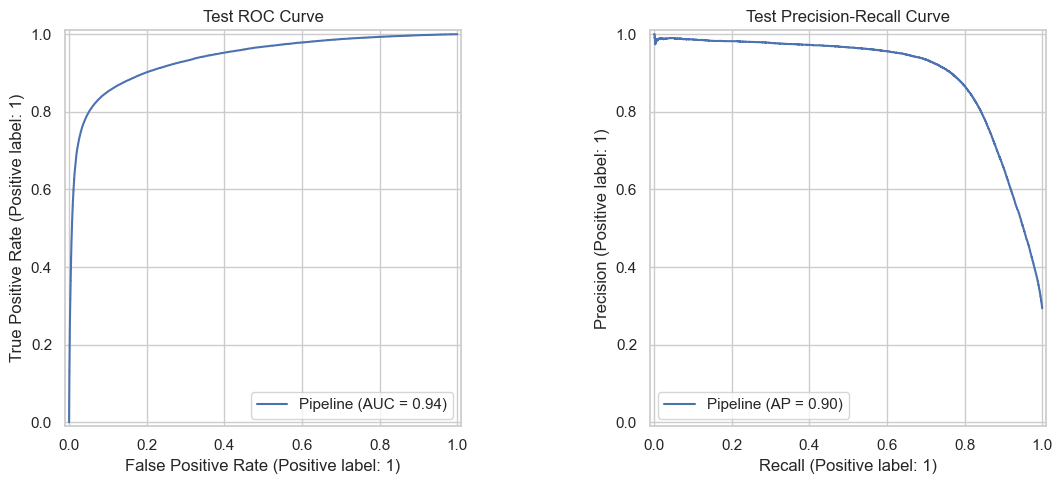

Confusion matrix for LIGHTGBM (test):


,Pred_0,Pred_1
Actual_0,139168,7283
Actual_1,12355,48547


Diagnostic curves for LIGHTGBM (test):


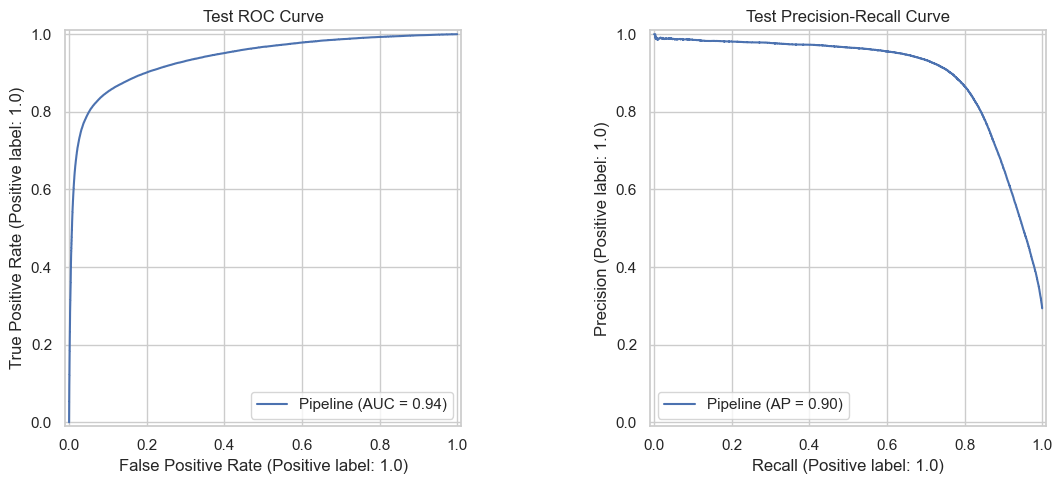

In [10]:
for model_name, registry in model_registry.items():
    test_preds = model_artifacts[model_name]["predictions"]["test"]
    cm_df = confusion_matrix_dataframe(y_test, test_preds)
    print(f"Confusion matrix for {model_name.upper()} (test):")
    display(cm_df)
    print(f"Diagnostic curves for {model_name.upper()} (test):")
    plot_diagnostics(registry["pipeline"], X_test, y_test)


## 7. Feature Importance & Interpretation

Best model by test ROC-AUC: xgboost


,mean_importance
last_fico_average,0.427155
term_months,0.003708
emp_length_years,0.001409
credit_history_years,0.001224
installment_to_income_ratio,0.001078
fico_average,0.000868
int_rate_decimal,0.000689
dti,0.000629
loan_amnt,0.000480
installment,0.000401


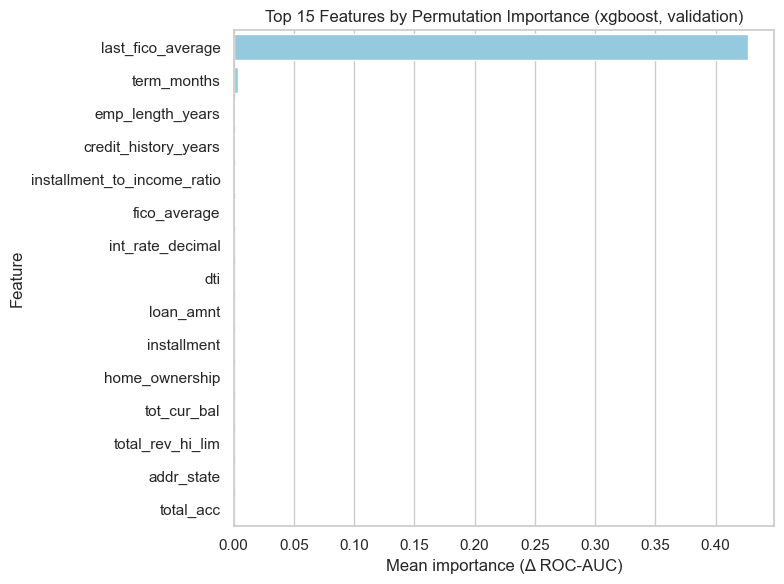

In [11]:
best_model_name = max(
    model_artifacts.keys(),
    key=lambda name: model_artifacts[name]["metrics"]["test"]["roc_auc"]
)
best_pipeline = model_registry[best_model_name]["pipeline"]
print(f"Best model by test ROC-AUC: {best_model_name}")

perm_series = permutation_importance_summary(best_pipeline, X_val, y_val)
display(perm_series.head(20).to_frame("mean_importance"))

plt.figure(figsize=(8, 6))
sns.barplot(
    x=perm_series.head(15),
    y=perm_series.head(15).index,
    orient="h",
    color="skyblue",
)
plt.title(f"Top 15 Features by Permutation Importance ({best_model_name}, validation)")
plt.xlabel("Mean importance (Δ ROC-AUC)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


Top SHAP importances for xgboost


last_fico_average              2.708322
term_months                    0.359839
installment_to_income_ratio    0.119973
int_rate_decimal               0.113492
credit_history_years           0.107986
emp_length_years               0.098360
fico_average                   0.095530
dti                            0.078397
loan_amnt                      0.076397
revol_util_decimal             0.048559
installment                    0.046533
total_rev_hi_lim               0.043922
tot_cur_bal                    0.036105
total_acc                      0.026500
annual_inc                     0.017227
home                           0.010225
pub_rec                        0.008663
mort_acc                       0.006985
revol_bal                      0.006632
pub_rec_bankruptcies           0.006066
dtype: float32

/var/folders/_h/v3zx4l357d3fgz8svznhxcjc0000gn/T/ipykernel_18479/4252779487.py:9: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


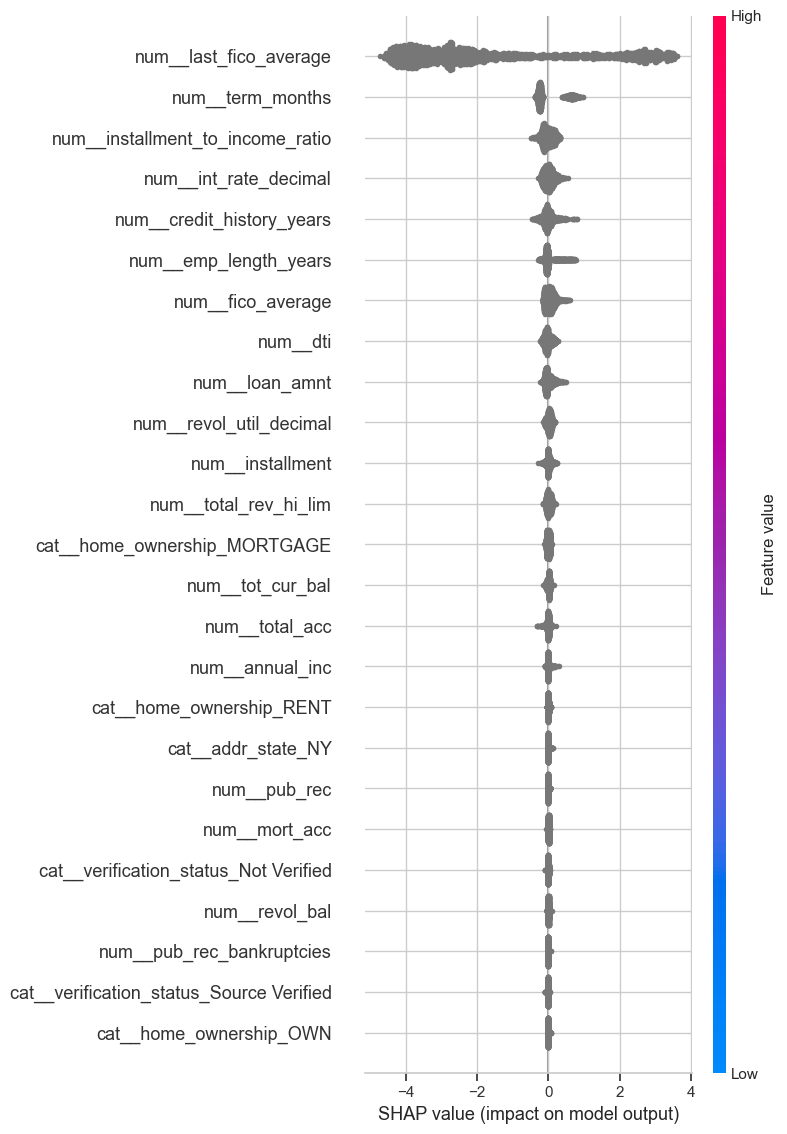

In [12]:
shap_agg_df = None
if CONFIG["enable_shap"]:
    try:
        shap_agg_df, shap_values, shap_transformed, shap_feature_names = compute_shap_importances(
            best_pipeline, X_test
        )
        print(f"Top SHAP importances for {best_model_name}")
        display(shap_agg_df.head(20))
        shap.summary_plot(
            shap_values,
            features=shap_transformed,
            feature_names=shap_feature_names,
            max_display=25,
        )
    except Exception as exc:
        shap_agg_df = None
        print(f"SHAP analysis skipped for {best_model_name}: {exc}")
else:
    print("SHAP analysis disabled via CONFIG['enable_shap'].")


## 8. Export Artifacts

In [21]:
metrics_payload = {}
for model_name, artifacts in model_artifacts.items():
    metrics_payload[model_name] = {
        split: {metric: float(value) for metric, value in scores.items()}
        for split, scores in artifacts["metrics"].items()
    }

best_params_payload = {name: registry["search"].best_params_ for name, registry in model_registry.items()}

paths = {
    "metrics": save_metrics(metrics_payload),
    "best_params": save_best_params(best_params_payload),
}

for model_name, artifacts in model_artifacts.items():
    predictions_export = test_df[[CONFIG["date_column"], CONFIG["target_column"]]].copy()
    predictions_export["predicted_label"] = artifacts["predictions"]["test"]
    predictions_export["predicted_probability"] = artifacts["probabilities"]["test"]
    paths[f"{model_name}_predictions"] = save_predictions(
        predictions_export,
        filename=f"test_predictions_{model_name}.csv",
    )
    paths[f"{model_name}_pipeline"] = save_pipeline(
        model_registry[model_name]["pipeline"],
        filename=f"{model_name}_pipeline.joblib",
    )

paths["permutation_importances"] = save_feature_importances(
    perm_series.rename("permutation_importance"),
    filename=f"feature_importances_permutation_{best_model_name}.csv",
)

if shap_agg_df is not None:
    paths["shap_importances"] = save_feature_importances(
        shap_agg_df.rename("mean_abs_shap"),
        filename=f"feature_importances_shap_{best_model_name}.csv",
    )

# print("Artifacts saved:")
# for name, path in paths.items():
#     print(f" - {name}: {path}")